Machine Learning Lab 4 - Arailym Kaiyrova

Exercise 0: Data Preprocessing

In [480]:
import numpy as np
import math
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [481]:
# reading from the file
data =  pd.read_csv('tic-tac-toe.data', sep=",")
data

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive
...,...,...,...,...,...,...,...,...,...,...
952,o,x,x,x,o,o,o,x,x,negative
953,o,x,o,x,x,o,x,o,x,negative
954,o,x,o,x,o,x,x,o,x,negative
955,o,x,o,o,x,x,x,o,x,negative


1. Convert any non-numeric values to numeric values.\
Since there were no much varitions of data in dataset, I simply replaced those strings or characters to specific number. For example by replacing 'x' to 1, 'o' to 0, 'b' to -1 as it can be seen below:

In [482]:
data.iloc[:, :].replace({"x": 1, "o": 0, "b": -1, "positive": 1, "negative": 0}, inplace=True)
data

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,1,1,1,1,0,0,0,1,0,1
1,1,1,1,1,0,0,0,0,1,1
2,1,1,1,1,0,0,0,-1,-1,1
3,1,1,1,1,0,0,-1,0,-1,1
4,1,1,1,1,0,0,-1,-1,0,1
...,...,...,...,...,...,...,...,...,...,...
952,0,1,1,1,0,0,0,1,1,0
953,0,1,0,1,1,0,1,0,1,0
954,0,1,0,1,0,1,1,0,1,0
955,0,1,0,0,1,1,1,0,1,0


2. If we group the dataset according to target value, it can be seen that the number of positive outcomes are much more than number of negative outcomes. That's why the goven dataset is unbalaced

In [496]:
data.groupby(['positive']).count()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3
positive,,,,,,,,,
0,332,332,332,332,332,332,332,332,332
1,625,625,625,625,625,625,625,625,625


Next step is to split data into, train, and test. The 'split_train_test' method below randomly splits the data into train and test sets according to given fraction of train data, which in this case is 0.8:

In [484]:
def split_train_test(df, frac):
    train=df.sample(frac=frac,random_state=200) #random state is a seed value
    test=df.drop(train.index)
    return train, test

train, test = split_train_test(data, 0.8)

Exercise 1: Logistic Regression with Gradient Descent

In this exercise, I started with diving data into components X_train, Y_train, X_test, Y_test according to target column name, which was done by method 'return_data_components' below, which splitted data into Input and target components according to target column name 'positive'

In [4]:
def return_data_components(trainset, testset, target):
    return trainset.drop([target], axis=1).to_numpy(),\
            trainset[target].to_numpy(),\
            testset.drop([target], axis=1).to_numpy(),\
            testset[target].to_numpy()    

train_x, train_y, test_x, test_y = return_data_components(train, test, 'positive')
train_x

NameError: name 'train' is not defined

Next, to implemet Gradient ascent algorithm, we need few components that will be necessary while learning a model\
\
First, 'likelihood' function below calculates the Likelihhod for given input, output, and current values of theta.\
Also, while calculating the likelihood, it also calculates prediction values of Y (sigmoid function), and gradient of likelihood function for current theta.

In [486]:
def likelihood(X, Y, teta):
    L = 0
    grad = np.zeros(len(teta))
    Y_PRED = np.zeros(len(Y))
    for i in range(len(Y)):
        x_teta = np.sum(np.matmul(X[i,:].T, teta))
        z = Y[i]*x_teta - np.log(1+math.exp(x_teta))
        Y_PRED[i]+=(1/(1+math.exp(-x_teta)))
        L+=z
        grad = np.add(grad, X[i,:]*(Y[i] - Y_PRED[i]))
    return L/len(Y), Y_PRED, grad

Next, funtion 'logLoss' below calculates logarithmic loss function for predicted sigmoid function values. This logLoss approach is used for measuring error for log functions, instead of RMSE in linear regression:

In [487]:
def logLoss(X, Y, teta):
    loss = 0
    for i in range(len(Y)):
        x_teta = np.sum(np.matmul(X[i,:].T, teta))
        y_pred = 1/(1+math.exp(-x_teta))
        z = -Y[i]*np.log(y_pred) - (1-Y[i])*np.log(1-y_pred)
        loss+=z
    return loss/len(Y)       

As it was required, bold driver approach was used for step-size selection in order to achieve faster convergence, and increase and decrease factors were set to 1.3 and 0.5

In [547]:
def bolddriver(X, Y, teta, mu_old):
    mu_pos, mu_neg = 1.3, 0.5
    mu_old*=mu_pos
    
    L_curr, Y_PRED, grad = likelihood(X, Y, teta)
    L_new = likelihood(X, Y, np.add(teta, mu_old*grad))[0]

    while L_curr > L_new:
        mu_old*=mu_neg
        teta = np.add(teta, mu_old*grad)
        L_new = likelihood(X, Y, teta)[0]
    print('Selected learnig rate for current iteration:', mu_old)
    return mu_old

Next main step is implementing Stochastic gradient descent (ascent for logistic regression) method.\
\
Stochastic gradient descent traing during each iteration different data chunks, and I selected each data row as one data chunk for each iteration.\
During each iteration, theta value is updated accoring to selected through bolddriver learning rate.\
Also, for currently updated theta, log loss value is calculated for test data, and stores to be able to use it later.

In [2]:
def SGD(X_train, Y_train, i_max, X_test, Y_test):
    r = 0.1
    #Initialize teta
    teta = [0]*X_train.shape[1]
    L, Y_PRED, grad = likelihood(X_train, Y_train, teta) 
    
    #Arrays for storing intermediate results
    log_losses = [logLoss(X_test, Y_test, teta)]
    likelihood_change = []
    
    for i in range(i_max):
        
        #Gradient of loss function
        x_teta = np.sum(np.matmul(X_train[i,:].T, teta))
        grad = X_train[i,:].transpose()*(Y_train[i] - (1/(1+math.exp(-x_teta))))
        
        #Updating learning rate for current iteration
        r = bolddriver(X_train, Y_train, teta, r)

        #Updating model parameters
        teta = np.add(teta, r*grad)
        #Calculate current log loss for test data and add to the list
        log_losses.append(logLoss(X_test, Y_test, teta))
        
        L_PREV = L
        L, Y_PRED, grad = likelihood(X_train, Y_train, teta)
        
        #Calculate current change in likelihood for test data and add to the list
        likelihood_change.append(abs(L-L_PREV))
        #if i>100 and L - L_PREV < 0.001: break #convergence criteria
        print('Loss value on trainset for current teta: ',L, "i", i)
    return teta, log_losses, likelihood_change

Results

In [3]:
teta_sgd, log_losses_sgd, likelihood_change_sgd = SGD(train_x, train_y, ә00, test_x, test_y)

NameError: name 'train_x' is not defined

From the line graph below it can be seen how log loss value for test data decreases after each iteraion

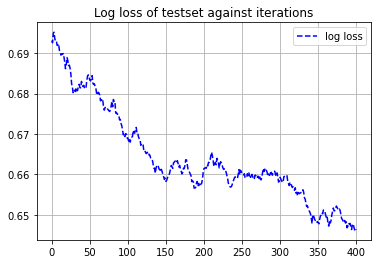

In [550]:
def plot_loss_convergence(log_losses):
    plt.plot(range(len(log_losses)), log_losses, 'b--', label='log loss')
    plt.title('Log loss of testset against iterations')
    plt.grid()
    plt.legend()
    plt.show()
    

plot_loss_convergence(log_losses_sgd)

However, there is no clear trend on the behaviour of change in the likelihood value. So, in some cases there a are slightly higher changes in likelihood function, in some cases there are smaller changes, but as the number of itertaions goes higher, there are smaller chages since the data is getting more trained.

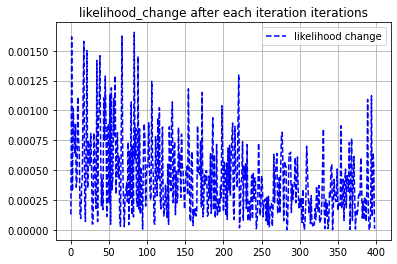

In [551]:
def plot_likelihood_change_convergence(likelihood_change):
    plt.plot(range(len(likelihood_change)), likelihood_change, 'b--', label='likelihood change')
    plt.title('likelihood_change after each iteration iterations')
    plt.grid()
    plt.legend()
    plt.show()

plot_likelihood_change_convergence(likelihood_change_sgd)

Exercise 2: Implement Newton Algorithm for Logistic Regression

In this task likelihood and logLoss functions were used from previous task.\
Newtons method is updating values of theta according to Hessian matrix, and gradient

In [454]:
from numpy.linalg import inv
def minimize_newton(Xtrain, Ytrain, Xtest, Ytest, r, i_max):
    teta = [0]*train_x.shape[1]
    
    #Using likelihood function from Exercise 1
    L, Y_PRED, g = likelihood(Xtrain, Ytrain, teta)
    
    #Arrays for storing intermediate results
    log_losses = [logLoss(Xtest, Ytest, teta)]
    likelihood_change = []
    
    for i in range(i_max):
        
        #Calculating Hessian according to formula H = X.T*W*X
        W = np.diag(np.multiply(Y_PRED, np.subtract(np.ones(len(Ytrain)), Y_PRED)))
        H = np.matmul(np.matmul(Xtrain.T, W), Xtrain)
        
        #Updating values of theta
        teta = teta+r*np.matmul(inv(H), g)
        
        log_losses.append(logLoss(Xtest, Ytest, teta))
        
        L_PREV = L
        L, Y_PRED, grad = likelihood(Xtrain, Ytrain, teta) 
        likelihood_change.append(abs(L-L_PREV))
        if L - L_PREV < 0.00001: break #convergence criteria
        print('Loss value on trainset for current teta: ',L, "i", i)
    return teta, log_losses, likelihood_change

Results

In [526]:
teta_newton, log_losses_newton, likelihood_change_newton = minimize_newton(train_x, train_y, test_x, test_y, 0.01, 400)

Loss val:  -0.6919559447257245 i 0
Loss val:  -0.6907766474078828 i 1
Loss val:  -0.689609222668301 i 2
Loss val:  -0.688453606586766 i 3
Loss val:  -0.6873097372439462 i 4
Loss val:  -0.6861775547052912 i 5
Loss val:  -0.6850570010058072 i 6
Loss val:  -0.6839480201357341 i 7
Loss val:  -0.6828505580271043 i 8
Loss val:  -0.681764562541156 i 9
Loss val:  -0.6806899834566403 i 10
Loss val:  -0.6796267724589583 i 11
Loss val:  -0.6785748831301793 i 12
Loss val:  -0.677534270939889 i 13
Loss val:  -0.6765048932368996 i 14
Loss val:  -0.6754867092417897 i 15
Loss val:  -0.6744796800402982 i 16
Loss val:  -0.673483768577551 i 17
Loss val:  -0.6724989396531312 i 18
Loss val:  -0.6715251599169823 i 19
Loss val:  -0.670562397866161 i 20
Loss val:  -0.6696106238424248 i 21
Loss val:  -0.6686698100306676 i 22
Loss val:  -0.6677399304582016 i 23
Loss val:  -0.6668209609948881 i 24
Loss val:  -0.6659128793541336 i 25
Loss val:  -0.6650156650947306 i 26
Loss val:  -0.6641292996235866 i 27
Loss val

From log loss graph below it can be seen that logarithmic loss decreased in a constant manner, and converged fast and gave lower log loss values than SGD.

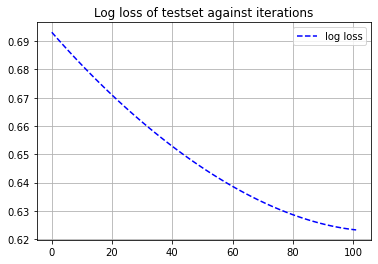

In [527]:
plot_loss_convergence(log_losses_newton)

The change in likelihood also decreased in a constant manner in comparison with SGD, which stay fluctuated.

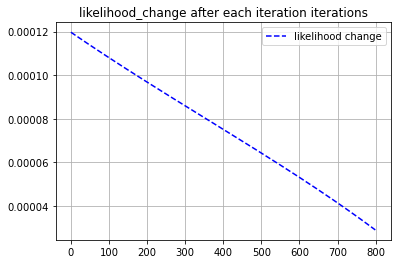

In [529]:
plot_likelihood_change_convergence(likelihood_change)